In [6]:
import random

runs_folder = 'Macro_Class_KRR6'
# lr = 1e-5
solvent_vectorizer = 'solvent_macro_props1'
solute_vectorizer = 'classification'
norm_bools = (True, True, True)
kernels =  ('linear', 'polynomial_2', 'polynomial_3', 'rbf',  'laplacian')

# epochs = 20

comments = f"""solute: {solvent_vectorizer}
                solute: {solute_vectorizer}
                norm: {norm_bools}
            """

In [2]:
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.metrics as met
from torch.utils.data import DataLoader
from my_nets.Create_dataset import *
from Vectorizers.vectorizers import *
from my_nets.LinearNet import *
from my_nets.ResNET import  *
from my_nets.net_func import *
import pickle
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import prettytable as pt
from sklearn.model_selection import GridSearchCV

In [7]:
for folder in ('Runs/', 'Run_results/'):
    try:
        os.makedirs(project_path(folder+runs_folder))
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

    with open(project_path(folder+runs_folder+'/comments.txt'), 'w') as f:
        f.write(comments)

In [8]:
table_v1 = pd.read_table(project_path('Tables/SS_table_v3.tsv'))
dataset = SS_Dataset(table_v1, solvent_vectorizer, solute_vectorizer, normalize=norm_bools)
len_data = dataset.__len__()
val_data = len_data // 10
train_dataset, val_dataset = dataset.train_val_split(0.9)

solvent_table = pd.read_table(project_path('Tables/solvent_test_table_v3.tsv'))
solute_table = pd.read_table(project_path('Tables/solute_test_table_v3.tsv'))
solvent_test_dataset = SS_Dataset(solvent_table, solvent_vectorizer, solute_vectorizer,
                                  normalize=norm_bools, show_norm_params=False)
solute_test_dataset = SS_Dataset(solute_table, solvent_vectorizer, solute_vectorizer,
                                 normalize=norm_bools, show_norm_params=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

solvent_test_loader = DataLoader(solvent_test_dataset, batch_size=46, shuffle=False)
solute_test_loader = DataLoader(solute_test_dataset, batch_size=64, shuffle=False)

print(f'train length: {len(train_loader.dataset)}')
print(f'val length: {len(val_loader.dataset)}')
print(f'solute test length: {len(solute_test_loader.dataset)}')
print(f'solvent test length: {len(solvent_test_loader.dataset)}')

length check-> Solvent: 2529, Solute: 2529, G_solv: 2529

Solvent
 std: tensor([ 0.0656,  0.2982,  0.2228, 24.6910, 28.1419,  0.3204,  0.2254]) 
 mean: tensor([ 1.4262,  0.1996,  0.2314, 48.5389, 17.9622,  0.1575,  0.0863])
Solute
 std: tensor([0.1118, 0.0344, 0.0628, 0.0864, 0.4906, 0.3262, 0.1882, 0.0687, 0.0841,
        0.1028, 0.0742, 0.2303, 0.3639, 0.3158, 0.2066, 0.1968, 0.2964, 0.1217,
        0.2748, 0.2168, 0.3017, 0.0444, 0.0886, 0.1433, 0.3441, 0.2498, 0.1618,
        0.1675, 0.1547, 0.0658, 0.0970, 0.0562, 0.0444, 0.2591, 0.1433, 0.1118,
        0.0596, 0.1921, 0.1322, 0.0990, 0.0687, 0.0715, 0.1995, 0.1263, 0.0949,
        0.1263, 0.1433, 0.1083, 0.0344, 0.0886, 0.1009, 0.1863, 0.1379, 0.0344,
        0.1232, 0.1547, 0.0742, 0.0841, 0.0487, 0.0444, 0.0687, 0.0397, 0.0344,
        0.1547, 0.1047, 0.0817, 0.0487, 0.0658, 0.0344, 0.0344, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.1083]) 
 mean: tensor([0.

In [9]:
def find_parameters(arg):
    assert arg in ('grid', 'seq'), 'wrong arg'
    if arg == 'grid':
        return find_parameters_grid
    elif arg == 'seq':
        return find_parameters_seq


def find_parameters_grid(train_dataset, parameters, reg_kwargs, lsn, repeat=1, best_params=None):
    param_grid = parameters.copy()
    # print(f'pg0: {param_grid}')
    if repeat == 0:
        for p, v in param_grid.items():
            # print(f'v - {v}, lsn - {lsn}, all - {v*(10**(lsn//2))}')
            param_grid[p] = np.geomspace(v*(10**(-lsn//2)), v*(10**(lsn//2)), lsn)
    else:
        for p, v in param_grid.items():
            print(f'where: {np.where(v == best_params[p])}')
            ind = np.where(v == best_params[p])[0].item()
            param_grid[p] = np.geomspace(v[ind-1],v[ind+1], lsn)

    found_best = {key: False for key in param_grid}
    # print(f'pg1: {param_grid}')
    while False in found_best.values():
        krr = KernelRidge(**reg_kwargs)
        # print(f'pg: {param_grid}')
        krr_gs = GridSearchCV(krr, param_grid, scoring='neg_mean_squared_error')
        krr_gs.fit(train_dataset.X, train_dataset.y)
        for key in parameters:
            best = krr_gs.best_estimator_.__getattribute__(key)

            if best == min(param_grid[key]):
                end = param_grid[key][1]
                start = (param_grid[key][0]/param_grid[key][-1])*end
                param_grid[key] = np.geomspace(start, end, lsn)
                print(f'{key} -> min: {best:.2e} in {[f"{v:.2e}" for v in param_grid[key]]}')
                found_best[key] = False

            elif best == max(param_grid[key]):
                start = param_grid[key][-2]
                end = (param_grid[key][-1]/param_grid[key][0])*start
                param_grid[key] = np.geomspace(start, end, lsn)
                print(f'{key} -> max: {best:.2e} in {[f"{v:.2e}" for v in param_grid[key]]}')
                found_best[key] = False

            else:
                found_best[key] = True
                best_params[key] = best
                print(f'{key} -> best: {best_params[key]:.2e} in {[f"{v:.2e}" for v in param_grid[key]]}')

    return best_params, param_grid


def find_parameters_seq(train_dataset, parameters, reg_kwargs, lsn, repeat=1):
    best_params = {}
    # print(f'p0: {parameters}')
    for key, value in parameters.items():
        # print(f'PARAM {key}')
        param_grid = parameters.copy()
        # print(f'pg1: {param_grid}')
        for p, v in param_grid.items():
            if p in best_params:
                v = best_params[p]
            param_grid[p] = [v,]
        if repeat == 0:
            param_grid[key] = np.linspace(value*0.3, value*3.3, lsn)
        else:
            param_grid[key] = np.linspace(value*(1-1/lsn), value*(1+1/lsn), lsn)

        found_best = False
        while not found_best:
            krr = KernelRidge(**reg_kwargs)
            print(f'pg: {param_grid}')
            krr_gs = GridSearchCV(krr, param_grid, scoring='neg_mean_squared_error')
            krr_gs.fit(train_dataset.X, train_dataset.y)
            best = krr_gs.best_estimator_.__getattribute__(key)

            if best == min(param_grid[key]):
                param_grid[key] = np.append(np.linspace(best/10, best, lsn), best*1.1)
                print(f'{key} -> min: {best} in {[f"{v:.2e}" for v in param_grid[key]]}')
            elif best == max(param_grid[key]):
                param_grid[key] = np.append(best*0.9, np.linspace(best, best*10, lsn))
                print(f'{key} -> max: {best} in {[f"{v:.2e}" for v in param_grid[key]]}')
            else:
                found_best = True
                best_params[key] = best
                ind = param_grid[key].tolist().index(best)
                param_grid[key] = np.linspace(param_grid[key][ind-1], param_grid[key][ind+1], lsn)
                print(f'{key} -> best: {best_params[key]:.2e} in {[f"{v:.2e}" for v in param_grid[key]]}')

    return best_params, param_grid


def parameter_search(fp_arg, train_dataset, kernel='linear', lsn=11, repeats=3):
    kernel_map = {'linear':{'parameters':{'alpha': 1,},
                            'reg_kwargs':{'kernel': 'linear'}},
                  'polynomial_2':{'parameters':{'alpha': 1, 'gamma':0.1},
                                  'reg_kwargs':{'degree': 2, 'kernel': 'polynomial'}},
                  'polynomial_3':{'parameters':{'alpha': 1, 'gamma':0.1},
                                  'reg_kwargs':{'degree': 3, 'kernel': 'polynomial'}},
                  'rbf':{'parameters':{'alpha': 1, 'gamma':0.1},
                         'reg_kwargs':{'kernel': 'rbf'}},
                  'laplacian':{'parameters':{'alpha': 1, 'gamma':0.1},
                               'reg_kwargs':{'kernel': 'laplacian'}}}
    parameters = kernel_map[kernel]['parameters']
    reg_kwargs = kernel_map[kernel]['reg_kwargs']

    best_params = {}
    for repeat in range(repeats):
        best_params, parameters = find_parameters(fp_arg)(train_dataset, parameters, reg_kwargs, lsn, repeat=repeat, best_params=best_params)
        print(f'------ repeat {repeat} ------')
        for key, value in best_params.items():
            print(f'{key}: {value:.2e}')

    # final grid check
    print('FINAL CHECK')
    krr = KernelRidge(**reg_kwargs)
    param_grid = {}
    for key, value in best_params.items():
        param_grid[key] = [0.8*value, 0.9*value, value, 1.1*value, 1.2*value]
    krr_gs = GridSearchCV(krr, param_grid, scoring='neg_mean_squared_error')
    krr_gs.fit(train_dataset.X, train_dataset.y)
    model = krr_gs.best_estimator_
    for key, value in param_grid.items():
        print(f'{key} - {krr_gs.best_estimator_.__getattribute__(key):.2e} in {[f"{v:.2e}" for v in value]}')

    return model

In [10]:
def get_curve(train_dataset, my_model):
    my_dataset = (train_dataset.X.copy(), train_dataset.y.copy())

    def get_part(part, dataset):
        zipped_dataset = list(zip(*dataset))
        random.shuffle(zipped_dataset)
        slice = int(len(dataset[0])*part)
        short_dataset = zipped_dataset[:slice]
        unzipped_dataset = list(zip(*short_dataset))
        return unzipped_dataset

    data = {'part':  np.linspace(0, 1, 20)[1:],
            'train':[], 'val':[], 'solvent':[], 'solute':[]}
    for part in data['part']:
        model = sklearn.base.clone(my_model, safe=True)
        X, y = get_part(part, my_dataset)
        model.fit(X, y)
        data['train'].append(met.mean_squared_error(y, model.predict(X)))
        for name, dataset in {'val':val_dataset, 'solvent': solvent_test_dataset, 'solute': solute_test_dataset}.items():
            data[name].append(met.mean_squared_error(dataset.y, model.predict(dataset.X)))

    return data



In [11]:
best_models = {}
training_curves = {}
for kernel in kernels:
    print(f'### KERNEL {kernel} ###')
    best_models[kernel] = parameter_search('grid' ,train_dataset, kernel=kernel, lsn=5, repeats=5)
    training_curves[kernel] = get_curve(train_dataset, best_models[kernel])

### KERNEL linear ###
alpha -> best: 5.62e+00 in ['1.00e-03', '1.78e-02', '3.16e-01', '5.62e+00', '1.00e+02']
------ repeat 0 ------
alpha: 5.62e+00
where: (array([3]),)


KeyboardInterrupt: 

In [12]:
all_curves = {'train':{}, 'val':{}, 'solvent':{}, 'solute':{}}
for kernel, data in training_curves.items():
    for key in all_curves:
        all_curves[key][kernel] = data[key]

In [13]:
training_curves_copy = training_curves.copy()

In [14]:
for kernel, data in training_curves.items():
    t = training_curves[kernel]['train']
    v = training_curves[kernel]['val']
    new_t, new_v = [], []
    for i, x in enumerate(t+v):
        if i%2:
            new_t.append(x)
        else:
            new_v.append(x)
    training_curves[kernel]['train'] = new_t
    training_curves[kernel]['val'] = new_v

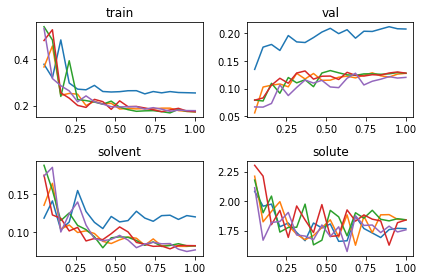

In [56]:
for dataset_name, sbp in {'train':221, 'val':222, 'solvent': 223, 'solute': 224}.items():
    plt.style='scientific'
    plt.subplot(sbp)
    plt.title(dataset_name)
    for kernel, data in all_curves[dataset_name].items():
        plt.plot(np.linspace(0, 1, 20)[1:], data)
plt.tight_layout()
plt.savefig(project_path(f'Run_results/{runs_folder}/training_curve.png'))

In [52]:
with open(project_path(f'Run_results/{runs_folder}/best_models.pkl'), 'wb') as f:
    pkl.dump(best_models, f)